In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import rotate

import os
import random

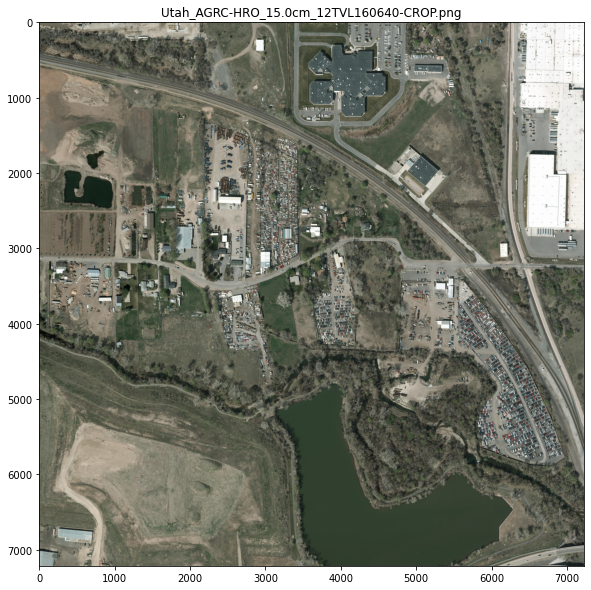

In [2]:
# load some image from data
image_path = random.choice(os.listdir("../data"))
img = np.asarray(Image.open(f"../data/{image_path}").convert("RGB"))
plt.figure(figsize=(10, 10))
plt.title(image_path)
plt.imshow(img)

In [3]:
def generate_random_gcps(img, num_samples, padding=(0, 0)):
    return np.random.randint(padding, 
                            high=(img.shape[0] - padding[0], img.shape[1] - padding[1]),
                            size=(num_samples, 2))

In [4]:
output_dim = (200, 200)
diag_len = np.ceil(np.sqrt(output_dim[0] ** 2 + output_dim[1] ** 2))
gcps = generate_random_gcps(img, 10, padding=(diag_len, diag_len))
gcps

array([[5382, 4618],
       [ 894, 2082],
       [1963, 4189],
       [2412, 6640],
       [6874,  843],
       [1886, 6474],
       [3022, 6294],
       [5147, 4872],
       [3779, 2480],
       [5725, 2534]])

In [5]:
def crop_around(img, centers, dim):
    x = centers.T[1] - dim[1] // 2
    y = centers.T[0] - dim[0] // 2
    return [img[p[0]:p[0]+dim[0], p[1]:p[1]+dim[1]] for p in zip(y, x)]

In [6]:
def center_crop(img, dim):
    return img[img.shape[0] // 2 - dim[0] // 2:img.shape[0] // 2 + dim[0] // 2,
               img.shape[1] // 2 - dim[1] // 2:img.shape[1] // 2 + dim[1] // 2]

In [7]:
def build_path(input_img, gcps, sample_dim, with_imgs=True):
    delta = np.diff(gcps, axis=0)
    directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
    angles = np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
    delta_angles = np.append(np.diff(angles), 0)

    sample_diag = np.floor(np.sqrt(sample_dim[0] ** 2 + sample_dim[1] ** 2)).astype("uint32")
    path = []

    if with_imgs:
        path_imgs = []
    
    for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
        steps = np.linalg.norm(t2 - t1) / 90  # segment_length / pixels_per_shot
        line = np.linspace(t1, t2, steps.astype('uint32'), dtype="uint32")
        path.extend([np.array([x, y, angle]) for (x, y) in line])

        if not with_imgs:
            continue

        # create image samples with appropriate rotation
        sample = crop_around(input_img, line, (sample_diag, sample_diag))
        rotated_sample = [center_crop(rotate(s, -angle, reshape=False), sample_dim) for s in sample]
        path_imgs.extend(rotated_sample)

        if delta_angle == 0:
            continue
    
        # end of segment, mock changing direction in place
        interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
        path.extend([np.array([line[-1][0], line[-1][1], theta]) for theta in interpolated_angles])
        path_imgs.extend([center_crop(rotate(sample[-1], -theta, reshape=False), sample_dim) for theta in interpolated_angles])
    
    return np.array(path), np.array(path_imgs)


In [8]:
trace, imgs = build_path(img, gcps, output_dim)

In [9]:
trace[280:305, 2]

array([131.53486593, 131.53486593, 131.53486593, 131.53486593,
       131.53486593, 131.53486593, 131.53486593,  61.26558112,
        -9.00370369,  -9.00370369,  -9.00370369,  -9.00370369,
        -9.00370369,  -9.00370369,  -9.00370369,  -9.00370369,
        -9.00370369,  -9.00370369,  -9.00370369,  -9.00370369,
        -9.00370369,  -9.00370369, -21.39660529, -33.7895069 ,
       -33.7895069 ])

In [10]:
np.unique(trace[:, 2], return_index=True)

(array([-150.53084217, -119.76551355, -119.76551355,  -76.77751022,
         -59.08800387,  -52.41421652,  -52.41421652,  -43.71604707,
         -33.7895069 ,  -21.39660529,   -9.00370369,   -9.00370369,
           1.58950582,    1.58950582,   13.60242079,   39.56032471,
          61.26558112,   63.09874803,   71.35890307,   79.6190581 ,
         131.53486593]),
 array([  0, 334, 335, 333, 366, 118, 119,  58, 303, 302, 288, 289, 368,
        367, 117, 201, 287,  59,  87,  88, 202]))

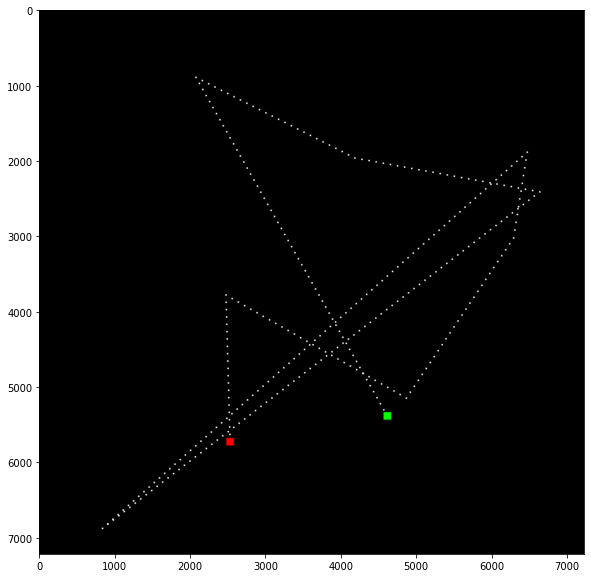

In [11]:
path_trace = np.zeros(img.shape)
for x, y, _ in trace:
    x = int(x)
    y = int(y)
    path_trace[x-10:x+10, y-10:y+10] = 1

x_start, y_start, _ = trace[0].astype("uint32")
x_end, y_end, _ = trace[-1].astype("uint32")
path_trace[x_start-50:x_start+50, y_start-50:y_start+50] = np.array([0, 1, 0])
path_trace[x_end-50:x_end+50, y_end-50:y_end+50] = np.array([1, 0, 0])

plt.figure(figsize=(10, 10))
plt.imshow(path_trace)

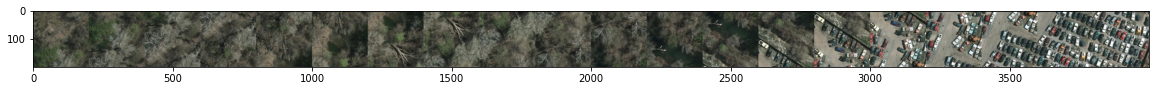

In [12]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(imgs[:20]))